In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import tifffile
import mbo_utilities as mbo
import fastplotlib as fpl

import dask.array as da

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Image(value=b'version https://git-lfs.github.com/spec/...', height='55', width='300')

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


In [5]:
from suite2p.io.binary import BinaryFile

In [10]:
tiff_path = r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled\plane_01_mk301.tiff"
out_file = "./out.bin"

In [11]:
import tifffile
import numpy as np
from suite2p.io.binary import BinaryFile
from pathlib import Path

def tiff_to_binary(tiff_path, out_path, dtype="int16"):
    data = tifffile.memmap(tiff_path)
    out_path = Path(out_path).with_suffix(".bin")
    
    if data.ndim != 3:
        raise ValueError("Must be assembled, 3D (T, Y, X)")
    
    nframes, x, y = data.shape
    bf = BinaryFile(Ly=Y, Lx=X, filename=str(Path(out_binary)), n_frames=T, dtype=dtype)
    
    bf[:] = data
    bf.close()
    
    print(f"Wrote binary file '{out_path}' with {T} frames of shape ({x},{y}).")

In [12]:
tiff_to_binary(tiff_path, out_file)

Wrote binary file './out.bin' with 64594 frames of shape (448,448) using dtype int16.


In [49]:
fname = r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled"
files = mbo.get_files(fname, 'tif', 1)
files[:2]

['D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_01_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_02_mk301.tiff']

In [ ]:
file = files=[0]

In [50]:
fname_scan = r"D:\W2_DATA\kbarber\2025_03_01\mk301\green\*"
raw_scan = mbo.read_scan(fname_scan)

Detected possible escaped characters in the path. Use a raw string (r'...') or double backslashes.


In [52]:
mbo.save_as(raw_scan, r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr", planes=[0, 7, 13], ext=".zarr")

Reading tiff series data...
Reading tiff pages...
Raw tiff fully read.


Saving plane 1:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 8:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 14:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216
Time elapsed: 0 minutes 33 seconds.


In [55]:
zpath = r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr"
arr = mbo.zarr_to_dask(zpath)

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
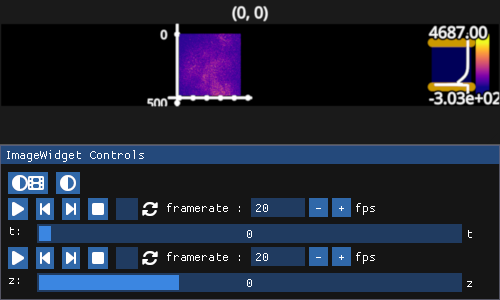

In [56]:
iw = fpl.ImageWidget(arr)
iw.show()

In [23]:
iw = mbo.run_gui(data)

Data provided and set.
Is running jupyter
Running jupyter, data provided. Making ImageWidget


ValueError: Found no accessible jobs in dask

In [4]:
iw.close()

NameError: name 'files' is not defined